# Preprocessing

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phuongkhanh21","key":"0fd6eb70e1509aad441adeb76f0dfff2"}'}

In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d berkanoztas/synthetic-transaction-monitoring-dataset-aml

import zipfile

with zipfile.ZipFile("synthetic-transaction-monitoring-dataset-aml.zip", 'r') as zip_ref:
    zip_ref.extractall("synthetic_transaction_data")

import pandas as pd
os.listdir("synthetic_transaction_data")
df = pd.read_csv("synthetic_transaction_data/SAML-D.csv")
df.head(5)

Dataset URL: https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml
License(s): CC-BY-NC-SA-4.0
synthetic-transaction-monitoring-dataset-aml.zip: Skipping, found more recently modified local copy (use --force to force download)


,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

**Custom train_test_split**

In [4]:
def custom_split(df, validation_dt=70, test_dt=35):
  # validation_cut_off=70: selects transactions for validation set, from the final 70 days prior to the dataset's latest date
  # test_cut_off=40: selects transactions for test set, from the final 70 days prior to the dataset's latest date

  test_cutoff = df['Date'].max() - pd.Timedelta(days=test_dt)
  validation_cutoff = df['Date'].max() - pd.Timedelta(days=validation_dt)

  test_set = df[df.Date >= test_cutoff]
  validation_set = df[(df.Date >= validation_cutoff) & (df.Date < test_cutoff)]
  train_set = df[df.Date < validation_cutoff]

  return train_set, validation_set, test_set

In [5]:
df_train, df_val, df_test = custom_split(df.copy())

In [6]:
df_train.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


**Feature engineering**

In [7]:
def temporal_features(df):

  df['year'] = df['Date'].dt.year
  df['month'] = df['Date'].dt.month
  df['day_of_month'] = df['Date'].dt.day
  df['day_of_week'] = df['Date'].dt.dayofweek
  df['day_of_year'] = df['Date'].dt.dayofyear
  df['hour'] = df['Time'].dt.hour
  df['minute'] = df['Time'].dt.minute
  df['second'] = df['Time'].dt.second

  return df


In [8]:
def feature_engineer(df):

  # dropping column Laundering_type
  df = df.drop(columns = ["Laundering_type"])

  # fanin_30d: Number of unique sender accounts that sent money to a given receiver in the past 30 days.
  df['fanin_30d'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='30D')])['Sender_account'].transform('nunique')

  # fan_in_out_ratio: For each account, the number of unique inbound counterparties divided by the number of unique outbound counterparties in a 30-day window.
  df['fanout_30d'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='30D')])['Receiver_account'].transform('nunique')
  df['fan_in_out_ratio'] = df['fanin_30d']/df['fanout_30d']
  df['fan_in_out_ratio'] = df['fan_in_out_ratio'].fillna(0)

  # fanin_intensity_ratio: Measures concentration—how many unique senders per daily inbound transaction.
  df['daily_receive'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='1D')])['Sender_account'].transform('nunique')
  df['fanin_intensity_ratio'] = df['fanin_30d']/df['daily_receive']
  df['fanin_intensity_ratio'] = df['fanin_intensity_ratio'].fillna(0)

  # amount_dispersion_std: Volatility of transaction amounts sent by each sender.
  df['amount_dispersion_std'] = df.groupby(['Sender_account'])['Amount'].transform('std')
  df['amount_dispersion_std'] = df['amount_dispersion_std'].fillna(0)

  # sent_to_received_ratio_monthly: For each account, total received amount divided by total sent amount over a monthly window.
  df['monthly_receive'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='ME')])['Amount'].transform('sum')
  df['monthly_send'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='ME')])['Amount'].transform('sum')
  df['sent_to_received_ratio_monthly'] = df['monthly_receive']/df['monthly_send']
  df['sent_to_received_ratio_monthly'] = df['sent_to_received_ratio_monthly'].fillna(0)

  # back_and_forth_transfers: Number of unique transfers from a sender account to a receiver account in a single calendar day.
  df['back_and_forth_transfers'] = df.groupby(['Sender_account', 'Receiver_account', pd.Grouper(key='Date', freq='1D')])['Amount'].transform('count')

  # daily_receiver_transaction/weekly_receiver_transaction: Number of unique transaction from a receiver account in a single/week calendar day.
  df['daily_receiver_transaction'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='1D')])['Amount'].transform('count')
  df['weekly_receiver_transaction'] = df.groupby(['Receiver_account', pd.Grouper(key='Date', freq='1W')])['Amount'].transform('count')

  # daily_sender_transaction/weekly_sender_transaction: Number of unique transaction from a sender account in a single/week calendar day.
  df['daily_sender_transaction'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='1D')])['Amount'].transform('count')
  df['weekly_sender_transaction'] = df.groupby(['Sender_account', pd.Grouper(key='Date', freq='1W')])['Amount'].transform('count')

  return df

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Time                    datetime64[ns]
 1   Date                    datetime64[ns]
 2   Sender_account          int64         
 3   Receiver_account        int64         
 4   Amount                  float64       
 5   Payment_currency        object        
 6   Received_currency       object        
 7   Sender_bank_location    object        
 8   Receiver_bank_location  object        
 9   Payment_type            object        
 10  Is_laundering           int64         
 11  Laundering_type         object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 870.2+ MB


In [10]:
def recast(df):
  exclude = ['Sender_account', 'Receiver_account']
  for col in df.select_dtypes(include=['int64', 'int32']).columns:
    if col not in exclude:
      if df[col].max() < 127:
        df[col] = df[col].astype('int8')
      elif df[col].max() < 32767:
        df[col] = df[col].astype('int16')
      elif df[col].max() < 2147483647:
        df[col] = df[col].astype('int32')
      else:
        df[col] = df[col].astype('int64')
  return df

In [11]:
df = recast(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9504852 entries, 0 to 9504851
Data columns (total 12 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Time                    datetime64[ns]
 1   Date                    datetime64[ns]
 2   Sender_account          int64         
 3   Receiver_account        int64         
 4   Amount                  float64       
 5   Payment_currency        object        
 6   Received_currency       object        
 7   Sender_bank_location    object        
 8   Receiver_bank_location  object        
 9   Payment_type            object        
 10  Is_laundering           int8          
 11  Laundering_type         object        
dtypes: datetime64[ns](2), float64(1), int64(2), int8(1), object(6)
memory usage: 806.7+ MB


In [12]:
import networkx as nx
import collections

In [13]:
def computing_circular_transaction(df):

  # circular_transaction_count: count of unique simple directed cycles that include an account (or a specific transaction edge) within 30 days.

  grouped = df.groupby(pd.Grouper(key='Date', freq='30D'))

  results = []

  for window_start, group in grouped:   # each 'group' is a DataFrame
      G = nx.DiGraph()
      # Now you can safely iterate rows of this group
      for _, row in group.iterrows():
          G.add_edge(row['Sender_account'], row['Receiver_account'])

      cycles = list(nx.simple_cycles(G))

      circular_count = collections.defaultdict(int)
      for cycle in cycles:
          for node in cycle:
              circular_count[node] += 1

      for node, count in circular_count.items():
          results.append({
              "Date": window_start,
              "Sender_account": node,
              "circular_transaction_count": count
          })

  cycle_features = pd.DataFrame(results)

  df = df.merge(
    cycle_features,
    on=['Date', 'Sender_account'],
    how='left'
    )

  df['circular_transaction_count'] = df['circular_transaction_count'].fillna(0)

  return df

**Applying feature engineering on training set**

In [14]:
df_train = temporal_features(df_train)
df_train.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type,year,month,day_of_month,day_of_week,day_of_year,hour,minute,second
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022,10,7,4,280,10,35,19
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out,2022,10,7,4,280,10,35,20
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out,2022,10,7,4,280,10,35,20
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In,2022,10,7,4,280,10,35,21
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits,2022,10,7,4,280,10,35,21


In [15]:
df_train = feature_engineer(df_train)
df_train.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,...,fanin_intensity_ratio,amount_dispersion_std,monthly_receive,monthly_send,sent_to_received_ratio_monthly,back_and_forth_transfers,daily_receiver_transaction,weekly_receiver_transaction,daily_sender_transaction,weekly_sender_transaction
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,...,2.000000,1798.528609,1459.15,1459.15,1.000000,1,1,1,1,1
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,...,1.000000,27454.063893,72252.38,1091821.92,0.066176,12,12,12,102,103
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,...,1.000000,20778.395683,14328.44,181662.45,0.078874,1,1,1,3,3
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,...,1.222222,79.885556,885090.99,107439.96,8.238006,9,83,83,9,9
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,...,3.000000,892.281108,5010.29,3342.19,1.499104,1,1,1,1,1


In [16]:
df_train = computing_circular_transaction(df_train)
df_train.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,...,amount_dispersion_std,monthly_receive,monthly_send,sent_to_received_ratio_monthly,back_and_forth_transfers,daily_receiver_transaction,weekly_receiver_transaction,daily_sender_transaction,weekly_sender_transaction,circular_transaction_count
0,1900-01-01 10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,...,1798.528609,1459.15,1459.15,1.000000,1,1,1,1,1,0.0
1,1900-01-01 10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,...,27454.063893,72252.38,1091821.92,0.066176,12,12,12,102,103,0.0
2,1900-01-01 10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,...,20778.395683,14328.44,181662.45,0.078874,1,1,1,3,3,0.0
3,1900-01-01 10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,...,79.885556,885090.99,107439.96,8.238006,9,83,83,9,9,0.0
4,1900-01-01 10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,...,892.281108,5010.29,3342.19,1.499104,1,1,1,1,1,0.0


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7429619 entries, 0 to 7429618
Data columns (total 34 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   Time                            datetime64[ns]
 1   Date                            datetime64[ns]
 2   Sender_account                  int64         
 3   Receiver_account                int64         
 4   Amount                          float64       
 5   Payment_currency                object        
 6   Received_currency               object        
 7   Sender_bank_location            object        
 8   Receiver_bank_location          object        
 9   Payment_type                    object        
 10  Is_laundering                   int64         
 11  year                            int32         
 12  month                           int32         
 13  day_of_month                    int32         
 14  day_of_week                     int32         
 15

In [18]:
df_train = recast(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7429619 entries, 0 to 7429618
Data columns (total 34 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   Time                            datetime64[ns]
 1   Date                            datetime64[ns]
 2   Sender_account                  int64         
 3   Receiver_account                int64         
 4   Amount                          float64       
 5   Payment_currency                object        
 6   Received_currency               object        
 7   Sender_bank_location            object        
 8   Receiver_bank_location          object        
 9   Payment_type                    object        
 10  Is_laundering                   int8          
 11  year                            int16         
 12  month                           int8          
 13  day_of_month                    int8          
 14  day_of_week                     int8          
 15

In [14]:
features = ['Amount', 'year', 'month', 'day_of_month', 'day_of_week', 'day_of_year', 'hour', 'minute', 'second',
            'fanin_30d', 'fan_in_out_ratio', 'fanin_intensity_ratio', 'amount_dispersion_std',
            'sent_to_received_ratio_monthly', 'back_and_forth_transfers',
            'daily_receiver_transaction', 'weekly_receiver_transaction',
            'daily_sender_transaction', 'weekly_sender_transaction',
            'circular_transaction_count', 'Is_laundering']

In [15]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
corr_matrix = df_train[features].corr()

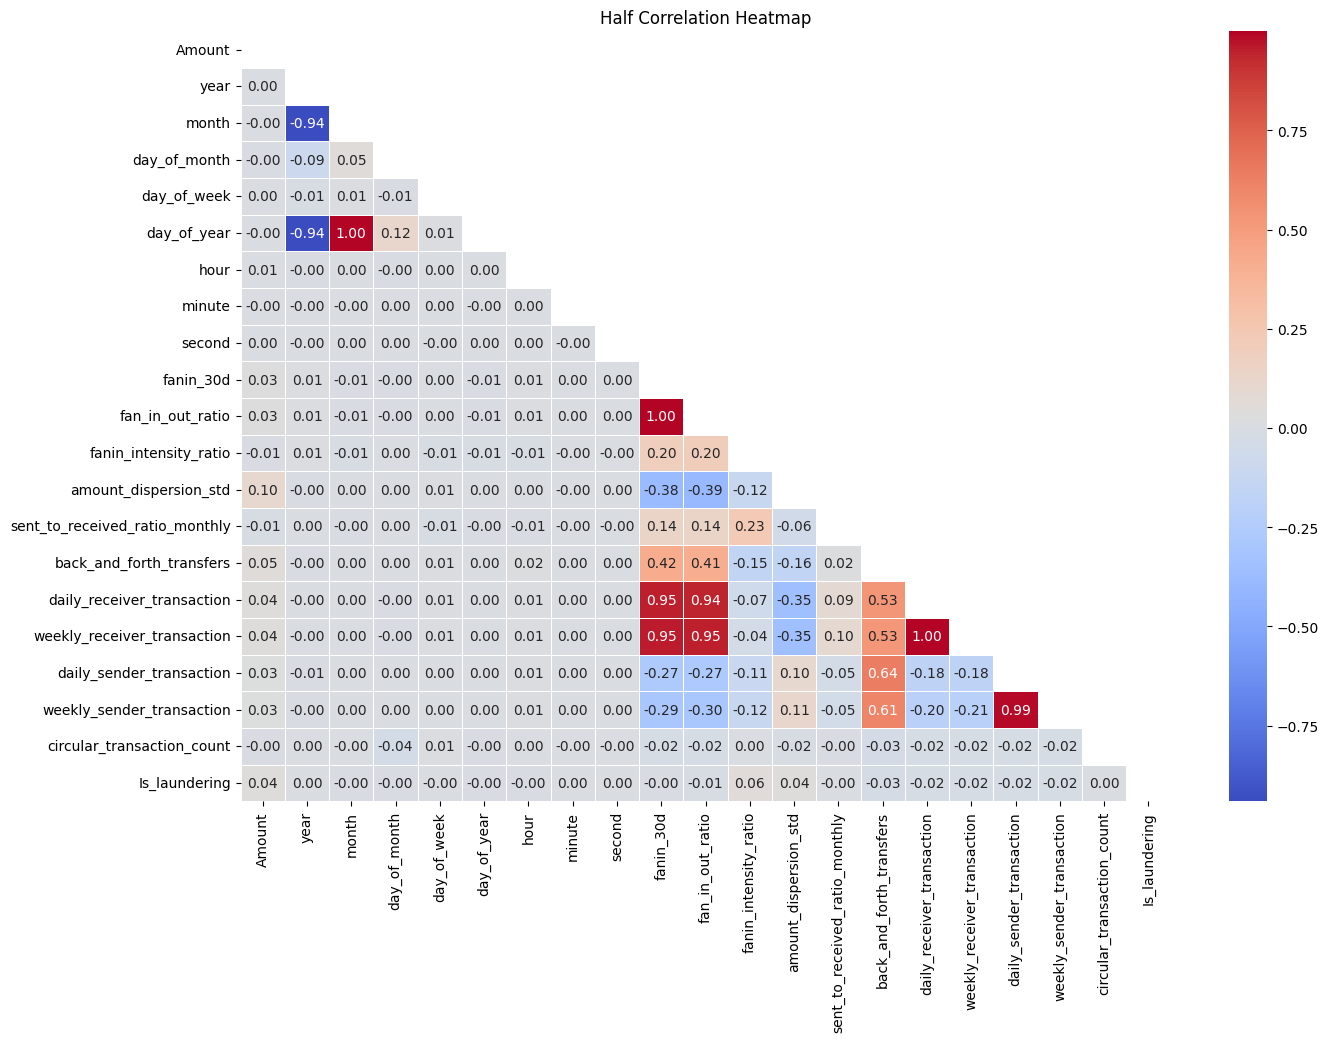

In [18]:
import numpy as np

mask = np.zeros_like(corr_matrix, dtype=bool) # Use bool for the mask
mask[np.triu_indices_from(mask)] = True

# 4. Draw the heatmap with the mask
plt.figure(figsize=(15, 10)) # Adjust figure size as needed
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Half Correlation Heatmap')
plt.show()

**XGBoost**

In [19]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [20]:
opt_features = ['year', 'month', 'day_of_month', 'day_of_week', 'day_of_year', 'hour', 'minute', 'second',
            'fanin_30d', 'fan_in_out_ratio', 'fanin_intensity_ratio', 'amount_dispersion_std',
            'sent_to_received_ratio_monthly', 'back_and_forth_transfers',
            'circular_transaction_count', 'Is_laundering']

In [ ]:
#grid = pd.DataFrame({'eta':[0.01,0.05,0.1]*2,
#                  'subsample':np.repeat([0.1,0.3],3)})

In [ ]:
'''
params = {
        'objective': 'binary:logistic',  # or 'reg:squarederror' for regression
        'eval_metric': 'logloss',            # or 'rmse' for regression
        'eta': 0.1,
        'max_depth': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }
    '''

In [21]:
df_val = temporal_features(df_val)
df_val = feature_engineer(df_val)
df_val = computing_circular_transaction(df_val)
df_val = recast(df_val)

In [22]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044845 entries, 0 to 1044844
Data columns (total 34 columns):
 #   Column                          Non-Null Count    Dtype         
---  ------                          --------------    -----         
 0   Time                            1044845 non-null  datetime64[ns]
 1   Date                            1044845 non-null  datetime64[ns]
 2   Sender_account                  1044845 non-null  int64         
 3   Receiver_account                1044845 non-null  int64         
 4   Amount                          1044845 non-null  float64       
 5   Payment_currency                1044845 non-null  object        
 6   Received_currency               1044845 non-null  object        
 7   Sender_bank_location            1044845 non-null  object        
 8   Receiver_bank_location          1044845 non-null  object        
 9   Payment_type                    1044845 non-null  object        
 10  Is_laundering                   1044845 no

In [23]:
import itertools
import pandas as pd
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score

# Define the hyperparameter grid

param_grid = {
    'max_depth': [3, 5, 10],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.3, 0.5, 1]
}

results = []

for max_depth, lr, subs in itertools.product(
        param_grid['max_depth'],
        param_grid['learning_rate'],
        param_grid['subsample']):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': float(lr),
        'subsample': float(subs),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_jobs': -1,
        'random_state': 42
    }

    clf = xgb.XGBClassifier(**params, n_estimators=500)
    clf.fit(df_train[opt_features[:-1]], df_train[opt_features[-1]], verbose=False)

    y_pred = clf.predict(df_val[opt_features[:-1]])

    f1 = f1_score(df_val[opt_features[-1]], y_pred)
    prec = precision_score(df_val[opt_features[-1]], y_pred)
    rec = recall_score(df_val[opt_features[-1]], y_pred)
    #acc = accuracy_score(y_val, y_pred)
    report = classification_report(df_val[opt_features[-1]], y_pred)

    results.append({
        'max_depth': max_depth,
        'learning_rate': lr,
        'subsample': subs,
        'f1_score': f1,
        'precision_score': prec,
        'recall_score': rec,
        #'accuracy': acc,
        'report': report,
        'model': clf
    })

# convert to DataFrame for easy sorting/inspection
df_results = pd.DataFrame([{k: v for k, v in r.items() if k != 'model'} for r in results])
df_results = df_results.sort_values('report', ascending=False).reset_index(drop=True)

# best entry and corresponding model
best = results[df_results.index[0]]
best_params = {'max_depth': best['max_depth'], 'learning_rate': best['learning_rate'], 'subsample': best['subsample']}
best_model = best['model']

print("Top 5 combos by weighted F1:")
print(df_results.head(5))
print("\nBest combo:", best_params)
print("\nClassification report for best model:")
print(best['report'])

Top 5 combos by weighted F1:
   max_depth  learning_rate  subsample  f1_score  precision_score  \
0          3           0.05        0.3  0.623936         0.970018   
1          3           0.05        1.0  0.659353         0.958533   
2          3           0.05        0.5  0.646733         0.957377   
3          5           0.01        0.5  0.634119         0.964164   
4          5           0.01        0.3  0.619048         0.961268   

   recall_score                                             report  
0      0.459866                precision    recall  f1-score   ...  
1      0.502508                precision    recall  f1-score   ...  
2      0.488294                precision    recall  f1-score   ...  
3      0.472408                precision    recall  f1-score   ...  
4      0.456522                precision    recall  f1-score   ...  

Best combo: {'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.3}

Classification report for best model:
              precision    recall

In [25]:
df_results.sort_values(by='f1_score', ascending=False)

,max_depth,learning_rate,subsample,f1_score,precision_score,recall_score,report
7,3,0.10,1.0,0.666667,0.947612,0.514214,precision recall f1-score ...
8,3,0.10,0.5,0.664130,0.948758,0.510870,precision recall f1-score ...
1,3,0.05,1.0,0.659353,0.958533,0.502508,precision recall f1-score ...
15,5,0.05,1.0,0.657005,0.917541,0.511706,precision recall f1-score ...
16,5,0.05,0.5,0.648942,0.924266,0.500000,precision recall f1-score ...
18,5,0.10,0.5,0.648908,0.894273,0.509197,precision recall f1-score ...
12,10,0.01,1.0,0.648884,0.929797,0.498328,precision recall f1-score ...
2,3,0.05,0.5,0.646733,0.957377,0.488294,precision recall f1-score ...
9,3,0.10,0.3,0.643805,0.950980,0.486622,precision recall f1-score ...
13,10,0.01,0.5,0.642896,0.934609,0.489967,precision recall f1-score ...
